# Capacity vs. dimensionality

author: steeve.laquitaine@epfl.ch  

**purpose**: what is effect of this sampling bias on the circuit's information capacity (IC)?
    
**methods**:
* contrast IC b/w random sampling vs. biased sampling.
* We focus on single-units
* multi-units have not one type by definition.


* sample a population of units such that we control number of each unit type (random vs biased), for each sorter

### Setup

Setup `manifold` env

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.features import features as feat
from src.nodes.analysis.code import igeom

# SETUP CONFIG
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT = data_conf["sorting"]["simulation"]["ground_truth"]["full"]["output"]
REC = data_conf["probe_wiring"]["output"]
IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]

# SORTINGS
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]
K3 = data_conf["sorting"]["sorters"]["kilosort3"]["full"]["output"]
K25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["full"]["output"]
K2 = data_conf["sorting"]["sorters"]["kilosort2"]["full"]["output"]
KS = data_conf["sorting"]["sorters"]["kilosort"]["full"]["output"]
HS = data_conf["sorting"]["sorters"]["herdingspikes"]["full"]["output"]
IGEOM_SAMP = data_conf["analyses"]["neural_code"]["by_sampling"]["igeom"]
IGEOM_DIM = data_conf["analyses"]["neural_code"]["by_dimensionality"]["igeom"]

# SETUP QUALITY PATH
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False
DT = 1.3

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

2024-10-15 20:17:56,463 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-15 20:17:56,855 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (14s)Unit type distribution

In [2]:
# reproducibility
# (14s) sample ground truth units to match sorted single-unit
# distribution. We get N ground truth units from each type
# to match its count in the sorted unit population
Sorting = si.load_extractor(K4)
SortingTrue = si.load_extractor(GT)
data = igeom.sample_gt_based_on_sorting_distribution(
    "KS4", Sorting, SortingTrue, quality_path, DT, seed=1
)

In [3]:
# unit-test
# counts should match
count_gt = feat.count_unit_type(
    data["df_gt"].iloc[data["gt_loc"]],
    data["unique_type"],
)
assert len(data["gt_loc"]) == sum(data["counts"]["count"]), "totals must match"
assert all(
    data["counts"]["count"].values == count_gt["count"].values
), "counts should match"

* Hypothesis 1: Information capacity should increase with the number of units, 
    
* Hypothesis 2: some unit responses could act as noise and entangle the neural manifold. The original paper shows that information capacity actually increases through the depth of a deep network (with decreasing layer size) as representations become disentangled.
* Results:
    * the capacity of the entire ground truth is lower than of a random sample of the same size as the sorted population.

* information capacity is robust to change in dimensionality as stated in the original paper.

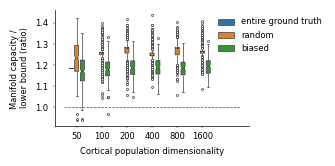

In [3]:
# LOAD/COMPUTE 1h34 for 0 bootstraps
igeom_df = pd.read_csv(IGEOM_DIM)
igeom_df.loc[igeom_df.Sorter == "ground_truth", "Sorter"] = "ground\ntruth"

# PLOT
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))

# set plot parameters
BOXPLOT_PMS = {
    "notch": True,
    "gap": 0.3,
    "width": 0.7,
    "linewidth": 0.5,
    "flierprops": {
        "marker": "o",
        "markerfacecolor": "w",
        "markersize": 1.5,
        "markeredgewidth": 0.5,
    },
}

# plot
ax = sns.boxplot(
    ax=ax,
    data=igeom_df,
    x="dimensionality",
    y="Capacity",
    hue="Sampling scheme",
    **BOXPLOT_PMS,
)
ax.hlines(xmin=-0.5, xmax=6.5, y=1, color="r", linestyle="--")
ax.set_ylabel("Manifold capacity / \nlower bound (ratio)")
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
ax.set_xlabel("Cortical population dimensionality")

# save
utils.savefig(
    PROJ_PATH + "/figures/4_code/supp_fig6A_capacity_by_dimensionality.svg",
)

In [9]:
# unit-test
N_BOOT = 200

assert (
    igeom_df[
        (igeom_df.Sorter == "KS4")
        & (igeom_df["Sampling scheme"] == "random")
        & (igeom_df["dimensionality"] == 50)
    ].shape[0]
    == N_BOOT
), "sample size does not match number of bootstraps"